# Classifier Training

## Common Imports and Settings

In [1]:
import sys
import os

root_path = os.path.dirname(os.getcwd())
src_path = os.path.join(root_path, "src")
sys.path.insert(0, src_path)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import torchvision
import torch
import pytorch_lightning as pl
import tissue_purifier as tp

matplotlib.rcParams["figure.dpi"] = 200

/opt/conda/lib/python3.7/site-packages/lightly/api/version_checking.py:57: Warning: You are using lightly version 1.1.13. There is a newer version of the package available. For compatability reasons, please upgrade your current version: pip install lightly==1.1.14
  warnings.warn(Warning(warning))


In [4]:
data_folder = = "/home/jupyter/data/slide-seq/original_data/"
#data_folder = "../slide-seq-data"

df_wt1 = pd.read_csv(os.path.join(data_folder, "wt_1.csv"))
df_wt2 = pd.read_csv(os.path.join(data_folder, "wt_2.csv"))
df_wt3 = pd.read_csv(os.path.join(data_folder, "wt_3.csv"))
df_dis1 = pd.read_csv(os.path.join(data_folder, "sick_1.csv"))
df_dis2 = pd.read_csv(os.path.join(data_folder, "sick_2.csv"))
df_dis3 = pd.read_csv(os.path.join(data_folder, "sick_3.csv"))

In [5]:
NUM_WORKERS = 8
BATCH_SIZE = 128
SEED = 1
MAX_EPOCHS = 100
INPUT_SIZE = 224
PIXEL_SIZE = 4.0
CROP_SIZE = INPUT_SIZE
INPUT_CHANNELS = 9
N_ELEMENT_MIN = 800
N_CROPS_TEST = 1600
# Model parameters:
NUM_FTRS = 128
PROJECTION_OUT_DIM = 128
# Optimizer parameters:
LEARNING_RATE = 0.001
IS_SCHEDULED = True
SCHEDULER_STEP = 3
SCHEDULER_GAMMA = 0.995

## Define helper functions

In [6]:
import lightly
import pytorch_lightning as pl
from pytorch_lightning.loggers import NeptuneLogger


def get_classifier_and_dataloader(dfs, labels, cl_model_path, classifier_path):
    print("Test Data:")
    test_sparse_images = tp.data_utils.SparseImage.from_pandas(
        dfs, x="x", y="y", category="cell_type", pixel_size=PIXEL_SIZE, padding=10
    )
    test_dataloader = tp.data_utils.helpers.define_dataloader_test(
        sparse_images=test_sparse_images,
        labels_sparse_images=labels,
        input_size=INPUT_SIZE,
        crop_size=CROP_SIZE,
        n_crops_test=N_CROPS_TEST,
        n_element_min=N_ELEMENT_MIN,
        batch_size=BATCH_SIZE,
    )
    model = tp.model_utils.helpers.define_model(
        number_of_channels=INPUT_CHANNELS,
        num_of_filters=NUM_FTRS,
        projection_out_dim=PROJECTION_OUT_DIM
    )
    ckpt = torch.load(cl_model_path)
    model.backbone.load_state_dict(ckpt["resnet18_parameters"])

    classifier = tp.model_utils.SimCLRBasedClassifier(
        model=model, embedding_out_dim=NUM_FTRS, out_dim=2, max_epochs=MAX_EPOCHS
    )
    classifier.fc.load_state_dict(torch.load(classifier_path))
    classifier = classifier.to("cuda")
    return classifier, test_dataloader

In [7]:
from sklearn.preprocessing import minmax_scale 
from tissue_purifier.data_utils.transforms import RandomGaussianBlur

def get_dense_image(df, pixel_size):
    t = RandomGaussianBlur(sigma=(1.0, 1.0))(
        tp.data_utils.SparseImage.from_panda(
            df, x="x", y="y", category="cell_type", pixel_size=pixel_size, padding=10
        ).to_dense()
    )
    
    a = np.zeros(t.shape)
    for i in range(9):
        a[i] = minmax_scale(t[i].cpu())
        
    return a.transpose((1, 2, 0))

In [8]:
from tissue_purifier.simple_cache import cache

offset = 0
CROP_SIZE = 224

def get_sickness_mask(image, image_label, threshold=0.5, return_probas=False):
    intensity_mask = np.zeros(image.shape[:-1])
    count_mask = np.zeros(image.shape[:-1])
    xys = cache["test"]
    for i, (proba, real_answer) in enumerate(zip(y_probas, y_true)):
        if real_answer == image_label:
            crop_i, crop_j = xys[indicies[i]]
            intensity_mask[
                crop_i + offset: crop_i + CROP_SIZE - offset, crop_j + offset: crop_j + CROP_SIZE - offset
            ] += proba
            count_mask[crop_i + offset: crop_i + CROP_SIZE - offset, crop_j + offset: crop_j + CROP_SIZE - offset] += 1
    
    count_mask = np.where(count_mask > 10, count_mask, 0)    
    
    proba_mask = intensity_mask / count_mask
    proba_mask = np.where(proba_mask == np.inf, 0, proba_mask)
    proba_mask = np.where(proba_mask == np.nan, 0, proba_mask)
    
    if return_probas:
        return proba_mask

    return np.where(proba_mask > threshold, 1, 0)

## Classifier 1 (Sample 1) masks

In [9]:
img_wt2 = get_dense_image(df_wt2, PIXEL_SIZE)
img_dis2 = get_dense_image(df_dis2, PIXEL_SIZE)

number of elements ---> 33059
The dense shape of the image is -> torch.Size([9, 1170, 845])
number of elements ---> 42776
The dense shape of the image is -> torch.Size([9, 1170, 1170])


In [20]:
classifier, test_dataloader = get_classifier_and_dataloader(
    dfs=[df_wt1, df_dis1],
    labels=[0, 1],
    cl_model_path="model.pth",
    classifier_path="classifier_1_fc.pt"
)

Test Data:
number of elements ---> 31659
The dense shape of the image is -> torch.Size([9, 1168, 1168])
number of elements ---> 27194
The dense shape of the image is -> torch.Size([9, 1166, 1170])


In [21]:
y_true = []
y_probas = []
indicies = []

for batch, labels, fnames in test_dataloader:
    y_true.append(labels.cpu())
    y_probas.append(torch.softmax(classifier(batch), dim=-1).cpu()[:, 1].detach())
    indicies.append(fnames)
    
    
y_probas = np.concatenate(y_probas)
y_true = np.concatenate(y_true)
indicies = np.concatenate(indicies)

In [22]:
y_probas.shape

(3200,)

In [25]:
mask_1 = get_sickness_mask(img_wt2, 0, threshold=0.57)#,return_probas=True)
mask_2 = get_sickness_mask(img_dis2, 1, threshold=0.49)#, return_probas=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


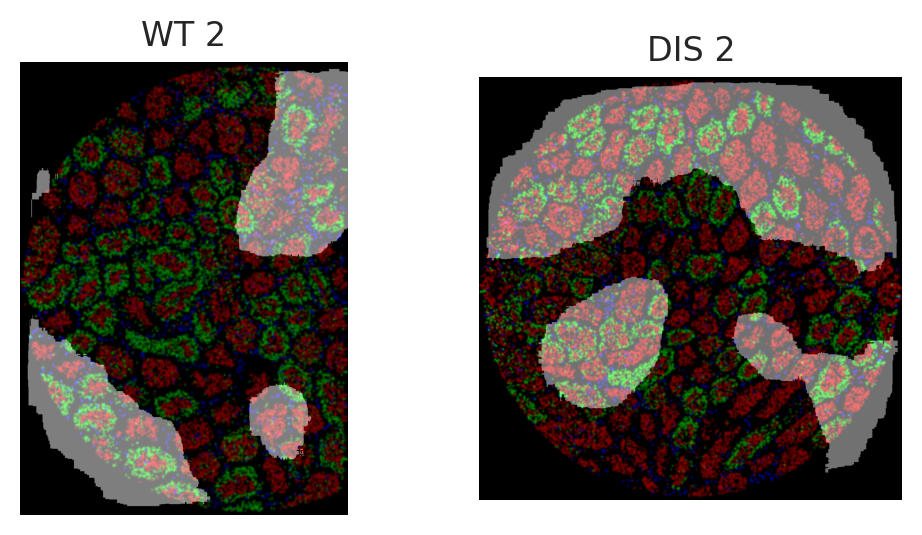

In [26]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(6,3))

ax1.imshow(img_wt2[:, :, :3])
ax1.imshow(mask_1, alpha=0.5, cmap="gray")
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title("WT 2");

ax2.imshow(img_dis2[:,:,:3])
ax2.imshow(mask_2, alpha=0.45, cmap="gray")
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title("DIS 2");

In [55]:
def get_probability(row, mask, x_min, y_min, pixel_size):
    i = int((row.y - y_min) / pixel_size)
    j = int((row.x - x_min) / pixel_size)
    return mask[j, i]

def get_mask_probas_for_df(df, mask, pixel_size):
    x_min, y_min = df.x.min(), df.y.min()
    return df.apply(lambda row: get_probability(row, mask, x_min, y_min, pixel_size=pixel_size), axis=1)

In [56]:
df_wt2["probas"] = get_mask_probas_for_df(df_wt2, mask_1, pixel_size=4)
df_dis2["probas"] = get_mask_probas_for_df(df_dis2, mask_2, pixel_size=4)

In [57]:
plt.style.use('default')
matplotlib.rcParams["figure.dpi"] = 200

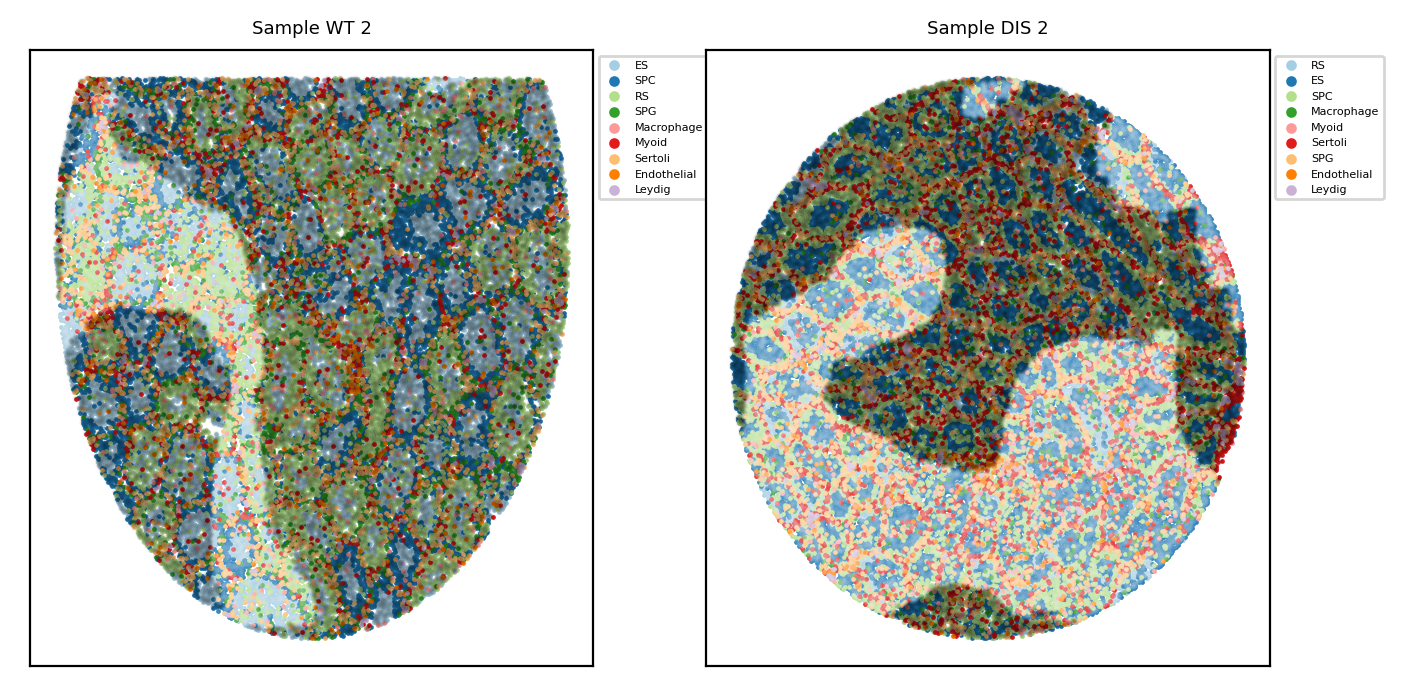

In [64]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8, 4))
tp.plot_utils.show_raw_data(df_wt2, title="Sample WT 2", ax=ax1, point_size=0.5, color_map=plt.cm.Paired)
tp.plot_utils.show_raw_data(df_dis2, title="Sample DIS 2", ax=ax2, point_size=0.5, color_map=plt.cm.Paired)
ax1.scatter(df_wt2.x, df_wt2.y, c=df_wt2.probas, alpha=0.07, s=1.5, cmap="gray")
ax2.scatter(df_dis2.x, df_dis2.y, c=df_dis2.probas, alpha=0.07, s=1.5, cmap="gray")
plt.show()